## Utilities

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import precision_score, recall_score, classification_report
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_csv('../DM_6_TASK1/df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

In [3]:
df['isKilled'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

In [4]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [5]:
to_discretize = ['date', 'state', 'city_or_county', 'party', 'incident_characteristics1']
df = discretize_data(df, to_discretize)

In [6]:
df.drop(columns=['date', 'state', 'city_or_county', 'party', 'incident_characteristics1'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   latitude                       166664 non-null  float64
 1   longitude                      166664 non-null  float64
 2   congressional_district         166664 non-null  int64  
 3   avg_age_participants           166664 non-null  float64
 4   n_participants_child           166664 non-null  int64  
 5   n_participants_teen            166664 non-null  int64  
 6   n_females                      166664 non-null  float64
 7   n_killed                       166664 non-null  float64
 8   n_injured                      166664 non-null  float64
 9   n_arrested                     166664 non-null  float64
 10  n_unharmed                     166664 non-null  float64
 11  n_participants                 166664 non-null  float64
 12  povertyPercentage             

In [7]:
col_to_drop = ['latitude', 'longitude', 'n_killed', 'candidatevotes', 'totalvotes', 'incident_gravity', 'females_rate',
       'minor_rate', 'arrested_rate', 'survival_rate',  'killed_rate', 'injured_rate',
       'killed_disp_per_district', 'injured_disp_per_district',
       'part_disp_per_district', 'winning_party_percentage', 'n_injured','n_unharmed', "incident_characteristics1_num"]

df.drop(columns=col_to_drop, axis=1,inplace=True)

In [8]:
label = df.pop('isKilled')

In [9]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.30,random_state=10, stratify=label)

In [10]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_trvl_undersample, y_trvl_undersample = undersample.fit_resample(X_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))

isKilled
0    0.5
1    0.5
Name: proportion, dtype: float64


In [12]:
X_trvl_undersample_df = pd.DataFrame(X_trvl_undersample, columns=X_trvl.columns)

In [13]:
def print_metrics_cv(results_hp_search, model_name):
    index_best_model = results_hp_search.best_index_ 
    results_dict = results_hp_search.cv_results_
    metrics_list=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    if model_name == 'MLP':
        metrics_list.append('mse')
    print(f"CV best configuration for {model_name}:")
    print(f"best parameters {results_dict['params'][index_best_model]}")
    for i in metrics_list:        
        if i == 'mse':
            print(f'Mean {i} train set: {abs(results_dict[f"mean_train_{i}"][index_best_model])} +/- {results_dict[f"std_train_{i}"][index_best_model]}')
            continue
        print(f'Mean {i} train set: {results_dict[f"mean_train_{i}"][index_best_model]} +/- {results_dict[f"std_train_{i}"][index_best_model]}')
    print("\n")
    for i in metrics_list:
        if i == 'mse':
            print(f'Mean {i} train set: {abs(results_dict[f"mean_test_{i}"][index_best_model])} +/- {results_dict[f"std_test_{i}"][index_best_model]}')
            continue
        print(f'Mean {i} validation set: {results_dict[f"mean_test_{i}"][index_best_model]} +/- {results_dict[f"std_test_{i}"][index_best_model]}')
    print("\n")

In [14]:
# Function that prints the classification report
def print_report_score(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['NotKilled', 'isKilled']))

# Function that prints the confusion matrix
def print_confusion_matrix(test_label, pred_label, model):
    cm = confusion_matrix(test_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

In [15]:
# Function extracting each grid from dictionary of grids
def list_grids(grids_dict):
    return [grids_dict[item] for item in grids_dict]

# Function performing gridsearch cv according to sklearn
def do_sklearn_GridSearchCV(model_name,model,param_grid,scoring,refit,cv,return_train_score,n_jobs,X_encoded,y):
    hp_search = GridSearchCV(model,
                                param_grid=param_grid,
                                scoring=scoring,
                                refit=refit,
                                cv=cv,
                                return_train_score=return_train_score,
                                n_jobs=n_jobs,
                                verbose=10
                                ).fit(X_encoded, y)


    results = pd.DataFrame(hp_search.cv_results_)
    if not os.path.isdir(f"cv_results/"):
        os.mkdir(f"cv_results/")

    results.to_csv(f"cv_results/{model_name}_cv_results.csv")

    return hp_search

## Grid Search EBM

We decided to use a grid search for the EBM model, as the other models used for the classification, in order to understand and analyse an optimal model configuration for accurate insights.

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()

ebm_grid = {
    'learning_rate': [0.01, 0.1, 0.05],
    'random_state': [10],
    'min_samples_leaf': [1, 2, 3],
    'max_leaves': [3, 5, 7]
    }

ebm_grid_search = do_sklearn_GridSearchCV('ebm', ebm, ebm_grid, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],"accuracy", cv_strategy, True, 4, X_trvl_undersample_df, y_trvl_undersample)


CV best configuration for EBM:
best parameters {'learning_rate': 0.1, 'max_leaves': 5, 'min_samples_leaf': 2, 'random_state': 10}
Mean accuracy train set: 0.7382717054894934 +/- 0.0008437675508958408
Mean precision train set: 0.7103059739292507 +/- 0.0010520399635526873
Mean recall train set: 0.8047646196448932 +/- 0.0009355362299597924
Mean f1 train set: 0.7545899694431508 +/- 0.0006685387513347434
Mean roc_auc train set: 0.8168804544703511 +/- 0.00100989568590564


Mean accuracy validation set: 0.7299397295976544 +/- 0.002679775171549595
Mean precision validation set: 0.7027434870454287 +/- 0.002829479352917121
Mean recall validation set: 0.7970353477765109 +/- 0.0036959121162122356
Mean f1 validation set: 0.7469195873501515 +/- 0.0024747236351806705
Mean roc_auc validation set: 0.8038604893141649 +/- 0.003428661741491769


Testing:
              precision    recall  f1-score   support

   NotKilled       0.90      0.67      0.77     36845
    isKilled       0.46      0.80      0.59 

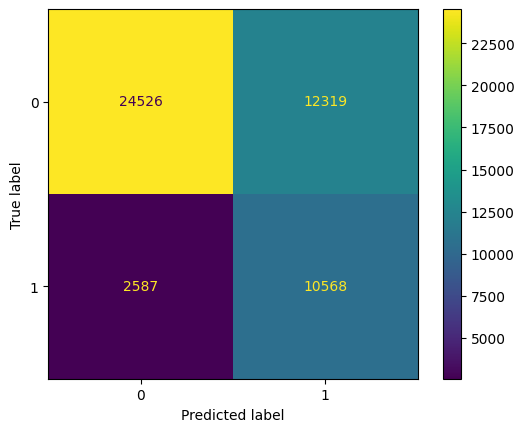

In [17]:
print_metrics_cv(ebm_grid_search,"EBM")
print("Testing:")
test_pred_ebm = ebm_grid_search.predict(X_test)
print_report_score(y_test,test_pred_ebm)
print_confusion_matrix(y_test,test_pred_ebm,ebm_grid_search)

## Global Explaination (training set)

In [18]:
from interpret import show

ebm_global = ebm_grid_search.best_estimator_.explain_global()
show(ebm_global)


<!-- http://127.0.0.1:7001/10813870416/ -->

From the global explaination we can see that n_participants & n_arrested (interaction) has a big impact on the involveKilling, 
i.e. when we have only a participant but no arrested people there is a good probability that that person died in the incident.
Or if we have 2 participants and 2 arrested, thoose criminals have been stopped before they could have killed someone.

The avg_age_participants influence the involveKilling prediction, in particular low ages add a < -1.5 value to the prediction operation.

Poverty percentage is less relevant than we expected, only if the poverty percentage is really low for a place the probability of a killing will be decrease, on the other hand, big values of poverty percentage don't correspond to a big increment in the probability of a killing involved.

Also the majority voted party has no relevant impact.

An interesting pattern can be observed in the number of arrests, specifically, when the number of arrested individuals increases, it decrease the probability of a killing being involved. This might be attributed to the timely police intervention when multiple individuals are arrested, preventing the situation from escalating.

A big amount of participants increases of course the probability of a killing.

A few cities or counties, as well as certain states, exhibit a noticeable impact on increasing or decreasing the probability of a killing.

## Local Explaination (Test set examples)

In [19]:
ebm_local = ebm_grid_search.best_estimator_.explain_local(X_test[4:8], y_test[4:8])
show(ebm_local)

<!-- http://127.0.0.1:7001/10931654928/ -->

We choose 4 examples from the local explaination to analyze them, to understand the impact of each relevant feature.

In the first case, the model predicted 0 while the actual outcome was 1. The intercept has a negative value, favoring zero. The number of arrests and participants combination pushes towards a higher chance of a killing, scoring 0.71. However, the state variable has a considerable negative impact of 0.66. Together, with the other negative factors, it has been obtained an incorrect prediction of 'no killing.' It's clear the model was uncertain in this case.

In the second example, the model made a mistake by predicting a 1 when the actual outcome was 0. This happened because of the high average age of participants and the combined effect of arrests and the number of participants. The model wasn't very sure about this prediction, more uncertain than in the first example.

In the third example, the model correctly predicted a killing because of the number of participants and arrests. However, the uncertainty came from the single person involved in the incident.

The fourth example stands out as a striking instance of an incident correctly predicted to not involve a killing. In this scenario, all individuals involved were arrested, resulting in a high probability of correctness at 0.98 for this prediction.



## Metrics

In [20]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, ebm_grid_search.best_estimator_.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.809


In [21]:
#calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, ebm_grid_search.best_estimator_.predict(X_test))
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.702


In [22]:
from interpret.perf import ROC

ebm_perf = ROC(ebm_grid_search.best_estimator_.predict_proba).explain_perf(X_test, y_test, name='EBM Adult')

show(ebm_perf)

<!-- http://127.0.0.1:7001/10811493392/ -->